In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
SEModel_path = '/content/drive/My Drive/CNN_Models/InceptionV3BasedModel4.keras'
img_path =  '/content/drive/MyDrive/Reverse/37/16.png'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
se_model = tf.keras.models.load_model(SEModel_path)

In [ ]:
# GradCAM implementation
def grad_cam(model, image, class_index, layer_name="mixed10"):
    """
    Generates GradCAM heatmap for a given image and class index.
    Args:
        model: Pretrained classification model.
        image: Input image array (preprocessed).
        class_index: Index of the class to visualize.
        layer_name: Name of the convolutional layer to use for GradCAM.
    Returns:
        heatmap: GradCAM heatmap (2D array).
    """
    # Create a model that outputs both the feature maps and predictions
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Watch the gradient of the class score with respect to the feature maps
    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)  # Ensure inputs are float32
        feature_maps, predictions = grad_model(inputs)  # Forward pass
        class_score = predictions[:, class_index]  # Target class score

    # Compute gradients of the class score with respect to feature maps
    grads = tape.gradient(class_score, feature_maps)

    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the feature maps using pooled gradients
    feature_maps = feature_maps[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(feature_maps * pooled_grads, axis=-1)

    # Apply ReLU to the heatmap
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

# Preprocess the image for InceptionV3
def preprocess_image(img_path):
    """
    Preprocess the image for InceptionV3.
    Args:
        img_path: Path to the input image.
    Returns:
        Preprocessed image array ready for the model.
    """
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    return img_array, np.array(img)

# Overlay the heatmap on the original image
def overlay_heatmap(heatmap, original_image, alpha=0.4):
    """
    Overlay the GradCAM heatmap onto the original image.
    Args:
        heatmap: GradCAM heatmap.
        original_image: Original image array (uint8 format).
        alpha: Transparency factor for the overlay.
    Returns:
        Combined image with heatmap overlay.
    """
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Convert to 0-255 scale
    heatmap = 255 - heatmap
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Combine heatmap with the original image
    superimposed_img = cv2.addWeighted(original_image, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed_img

#GradCAM

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


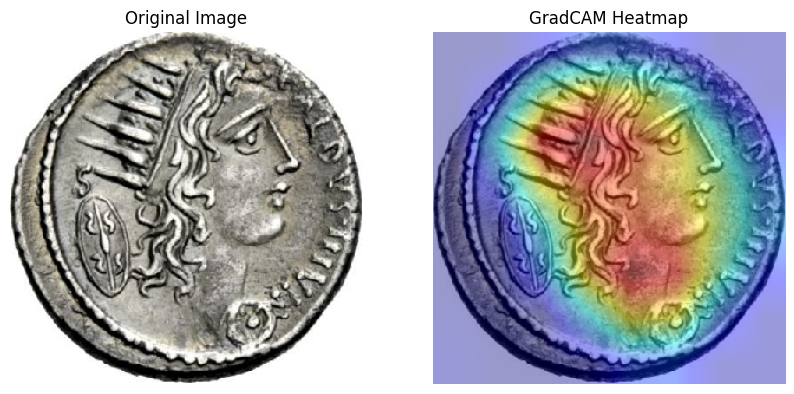

In [ ]:
# Run GradCAM on an example image
image, original_image = preprocess_image(img_path)

# Get model predictions
predictions = se_model.predict(image)
class_index = np.argmax(predictions[0])  # Class index with the highest probability

# Generate GradCAM heatmap
layer_name = "mixed10"  # Last InceptionV3 convolutional layer
heatmap = grad_cam(se_model, image, class_index, layer_name)

# Overlay the heatmap on the original image
overlayed_image = overlay_heatmap(heatmap, original_image)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("GradCAM Heatmap")
plt.imshow(overlayed_image)
plt.axis("off")
plt.savefig("GradCAM.png")
plt.show()